In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
# Load results from previous fit.
#filename = 'ryan_iris_bnp_full_data_fit_alpha8.0.json'
#filename = 'ryan_simulation_bnp_full_data_fit_alpha1.0.json'
filename = 'ryan_simulation_bnp_full_data_fit_alpha1.0.json'
json_input_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [4]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 4.94219872e-01 -5.02553164e-01 -1.50129262e+00  1.44611002e+00
  -8.60116511e-02  2.99899606e-01 -8.21160897e-03 -2.33951169e-03
  -7.96009427e-04 -2.89341340e-04 -1.09959456e-04 -1.09959541e-04]
 [ 5.37078601e-01 -5.21003176e-01 -1.51280097e+00  6.86712711e-01
   2.86816504e-01 -1.15191164e-01  1.02012193e-02  3.20581680e-03
   1.12390469e-03  4.04996467e-04  1.44889140e-04  1.44888721e-04]]
	cluster_weights:
[4.16828681e-01 3.30799689e-01 2.48023110e-01 3.04000227e-03
 7.06084748e-04 3.09783619e-04 1.47655640e-04 7.27298364e-05
 3.61711229e-05 1.80519646e-05 9.02074734e-06 9.02074734e-06]
	v_sticks:
[-3.36147171e-01  2.71078276e-01  4.15580988e+00  1.02169943e+00
  2.22352577e-01  8.42543592e-02  2.75574502e-02  9.80599206e-03
  3.29468528e-03  8.90324866e-04  4.76839732e-11]


In [5]:
print(model.prior_params)

prior_params:
	alpha: [1.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.  ]
 [0.   0.62]]


In [6]:
# Define a perturbation in the logit v space.

phi_center = 0.
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))

0.6931471805599453


In [37]:
import scipy as osp

class PriorPerturbation(object):
    def __init__(self, model, log_phi, epsilon=1.0):
        self.logit_v_lb = -4
        self.logit_v_ub = 4
        
        self.model = model
        
        self.epsilon_param = vb.ScalarParam('epsilon', lb=0.0)
        self.epsilon_param.set(epsilon)

        self.set_log_phi(log_phi)
        
        if not model.vb_params.use_logitnormal_sticks:
            raise NotImplementedError(
                'functional sensitivty only computed with logitnormal sticks')
        self.model = model
        
        self.objective = obj_lib.Objective(
            self.model.global_vb_params, self.get_perturbed_kl)
        
    def get_epsilon_phi(self, x):
        # You need to differentiate this at epsilon = 0, so don't take the log.
        #return np.exp(self.log_phi(x) + np.log(self.epsilon_param.get()))
        return np.exp(self.log_phi(x)) * self.epsilon_param.get()
        
    def get_e_log_perturbation(self):
        return \
            -1 * np.sum(gmm_utils.get_e_log_perturbation_vec(
                    self.model.vb_params, self.get_epsilon_phi))

    def get_perturbed_kl(self):
        return self.get_e_log_perturbation() + self.model.set_z_get_kl()
        
    # The log variational density of stick k at logit_v
    # in the logit_stick space.
    def get_log_q_logit_stick(self, logit_v, k):
        mean = self.model.global_vb_params['v_sticks']['mean'].get()[k]
        info = self.model.global_vb_params['v_sticks']['info'].get()[k]
        return -0.5 * (info * (logit_v - mean) ** 2 - np.log(info))

    # Return a vector of log variational densities for all sticks at logit_v
    # in the logit stick space.
    def get_log_q_logit_all_sticks(self, logit_v):
        mean = self.model.global_vb_params['v_sticks']['mean'].get()
        info = self.model.global_vb_params['v_sticks']['info'].get()
        return -0.5 * (info * (logit_v - mean) ** 2 - np.log(info))

    def get_log_p0(self, v):
        alpha = self.model.prior_params['alpha'].get()
        return (alpha - 1) * np.log1p(v) - self.log_norm_p0

    def get_log_p0_logit(self, logit_v):
        alpha = self.model.prior_params['alpha'].get()
        return \
            logit_v - (alpha + 1) * np.log1p(np.exp(logit_v)) - \
            self.log_norm_p0_logit

    def get_log_pc(self, v):
        logit_v = np.log(v) - np.log(1 - v)
        epsilon = self.epsilon_param.get()
        if np.abs(epsilon) < 1e-8:
            return self.get_log_p0(v)            
        else:
            log_epsilon = np.log(epsilon)
            return \
                self.get_log_p0(v) + \
                self.log_phi(logit_v) + \
                log_epsilon - \
                self.log_norm_pc

    def get_log_pc_logit(self, logit_v):
        epsilon = self.epsilon_param.get()
        if np.abs(epsilon) < 1e-8:
            return self.get_log_p0_logit(logit_v)            
        else:
            log_epsilon = np.log(epsilon)
            return \
                self.get_log_p0_logit(logit_v) + \
                self.log_phi(logit_v) + \
                log_epsilon - \
                self.log_norm_pc_logit

    # Setting functions for initialization
    def set_epsilon(self, epsilon):
        self.epsilon_param.set(epsilon)
        self.set_log_phi(self.log_phi)
        
    def set_log_phi(self, log_phi):
        # Set attributes derived from phi and epsilon
        
        # Initial values for the log normalzing constants which will be set below.
        self.log_norm_p0 = 0
        self.log_norm_pc = 0
        self.log_norm_p0_logit = 0
        self.log_norm_pc_logit = 0

        self.log_phi = log_phi
        
        norm_p0, _ = osp.integrate.quadrature(
            lambda v: np.exp(self.get_log_p0(v)), 0, 1)
        assert norm_p0 > 0 
        self.log_norm_p0 = np.log(norm_p0)

        norm_pc, _ = osp.integrate.quadrature(
            lambda v: np.exp(self.get_log_pc(v)),
            0, 1)
        assert norm_pc > 0 
        self.log_norm_pc = np.log(norm_pc)
        
        norm_p0_logit, _ = osp.integrate.quadrature(
            lambda logit_v: np.exp(self.get_log_p0_logit(logit_v)),
            self.logit_v_lb, self.logit_v_ub)
        assert norm_p0_logit > 0 
        self.log_norm_p0_logit = np.log(norm_p0_logit)

        norm_pc_logit, _ = osp.integrate.quadrature(
            lambda logit_v: np.exp(self.get_log_pc_logit(logit_v)),
            self.logit_v_lb, self.logit_v_ub)
        assert norm_pc_logit > 0 
        self.log_norm_pc_logit = np.log(norm_pc_logit)
        

prior_perturbation = PriorPerturbation(model, log_phi)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

0.0 -1.3510778981832263 -0.03663537377491137 -1.314446956474002


phi max:  0.49989900265152387


Text(0.5,1,'Priors in logit space')

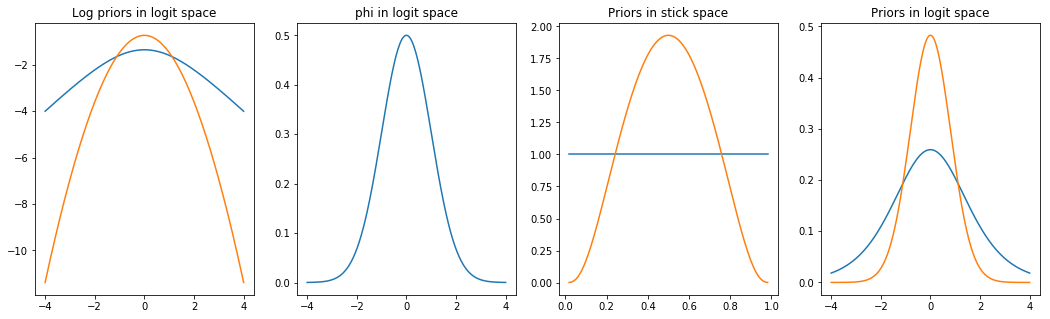

In [38]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(-4, 4, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [34]:
# Choose the number of GH points.
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

perturbed_log_density = lambda x : np.log(1.0 + phi(x))

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        gmm_utils.get_e_log_perturbation_vec(vb_params, phi))

expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1) 
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

33 33 96


In [11]:
# First fit with no perturbation but the increased number of gh points.
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 14.107183366096095	 Objective: -273.64843782554385
Iter: 1	 RMSE: 14.107208149949187	 Objective: -273.6484460627952
Iter: 2	 RMSE: 14.107234145079005	 Objective: -273.6484460886525
Optimization terminated successfully.
         Current function value: -273.648446
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Iter: 3	 RMSE: 14.107234145079005	 Objective: -273.64844608865553
Iter: 4	 RMSE: 14.10723429527361	 Objective: -273.64844608865815
Optimization terminated successfully.
         Current function value: -273.648446
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter: 5	 RMSE: 14.107234295273608	 Objective: -273.64844608865855
Iter: 6	 RMSE: 14.10723429531769	 Objective: -273.64844608865724
         Current function value: -273.648446
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1


In [39]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=prior_perturbation.model.global_vb_params,
        output_par=moment_model.moment_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=moment_model.set_moments,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [40]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

1.1072243533720212

## Fit with perturbation

epsilon: [0.]


In [42]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(1.0)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_0,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

# best_param_phi, kl_hessian_phi, kl_hessian_corrected_phi, \
#     init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
#     model.optimize_full(
#         best_param_0,
#         init_max_iter=100,
#         final_max_iter=500)

print('Done. ')

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0
Iter  0  value:  -276.1785857653942
Iter  1  value:  -276.26869908214434
Iter  2  value:  -276.09845305344913
Iter  3  value:  -276.27478411889234
Iter  4  value:  -276.2749677293017
Iter  5  value:  -276.2753976789561
Iter  6  value:  -276.2754182601624
Iter  7  value:  -276.27541833415455
Iter  8  value:  -276.2754183341593
Optimization terminated successfully.
         Current function value: -276.275418
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 8
         Hessian evaluations: 0
Iter  9  value:  -276.2754183341588
Iter  10  value:  -276.2754183341572
         Current function value: -276.275418
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 
This is nonzero if phi did anything: 0.8750158504090774


In [43]:
epsilon = prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  1.1072243533720214


Epsilon: 1.0


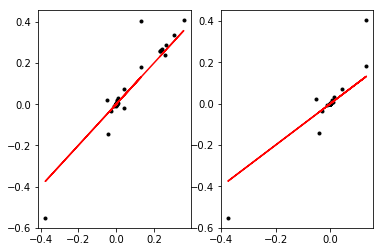

In [44]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
plt.plot(output_phi - output_0, output_phi - output_0, 'r')

## Influence function stuff  -- outdated

In [ ]:
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)

In [ ]:
influence_vals = np.array([
    stick_sens.get_all_stick_influence(logit_v) for logit_v in logit_v_grid ])

In [ ]:
def get_log_q_grad_vec(self, logit_v):
    log_q_grad_vec = np.array([
        self.log_q_logit_stick_obj.fun_free_grad(
            self.best_param, logit_v=logit_v, k=k)
        for k in range(self.model.k_approx - 1) ])
    return log_q_grad_vec
log_q_grads = np.array([ get_log_q_grad_vec(stick_sens, logit_v) for logit_v in logit_v_grid ])

In [ ]:
log_p0 = stick_sens.get_log_p0_logit_stick(logit_v_grid)
log_q_vec = np.array([
    stick_sens.get_log_q_logit_all_sticks(logit_v) \
    for logit_v in logit_v_grid ])

print(log_q_grads.shape)
print(log_p0.shape)
print(log_q_vec.shape)


In [ ]:
def get_all_stick_influence_times_phi(self, logit_v_grid, log_q_grads, log_phi, log_epsilon=0):
    # The prior is the same for every stick.
    log_p0 = stick_sens.get_log_p0_logit_stick(logit_v_grid)[:, np.newaxis]
    log_perturbation = log_phi(logit_v_grid)[:, np.newaxis] + log_epsilon
    log_q_vec = np.array([
        stick_sens.get_log_q_logit_all_sticks(logit_v) \
        for logit_v in logit_v_grid ])

    #print(log_q_vec.shape)
    #print(log_p0.shape)
    #print(log_perturbation.shape)
    
    #dens_ratios = np.exp(log_q_vec - log_p0 + log_perturbation)
    dens_ratios = np.exp(log_q_vec + log_perturbation)
    #print(self.lr_mat.shape)
    #print(log_q_grads.shape)
    #print(dens_ratios.shape)
    
    # d indexes the free parameters
    # g indexes the moments of interest
    # n indexes the grid points in logit_v_grid
    # k indexes the stick
    return(np.einsum('dg,nkd,nk->ng', self.lr_mat, log_q_grads, dens_ratios))

influence_phi_vals = \
    get_all_stick_influence_times_phi(
        stick_sens, logit_v_grid, log_q_grads, log_phi, log_epsilon=log_epsilon)

In [ ]:
#plt.plot(logit_v_grid, influence_phi_vals[:, 0]);
plt.plot(logit_v_grid[1:], (np.diff(logit_v_grid)[:, np.newaxis] * influence_phi_vals[1:,0]).T);

In [ ]:
def get_moments(free_par, moment_model):
    moment_model_copy = deepcopy(moment_model)
    moment_model_copy.set_moments_from_free_par(free_par)
    return moment_model.moment_params.get_vector()

pred_influence = np.sum(
    np.diff(logit_v_grid)[:, np.newaxis] * influence_phi_vals[1:,:], axis=0)
print(pred_influence.shape)

true_moment_diff = get_moments(best_param_phi, moment_model) - get_moments(best_param_0, moment_model)

In [ ]:
plt.plot(pred_influence, true_moment_diff, 'k.')
plt.plot(true_moment_diff, true_moment_diff, 'r')